对单词和字符进行one-hot编码

In [3]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

max_length = 10

results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
            index = token_index.get(word)
            results[i, j, index] = 1

字母级的one_hot编码略，手动方式太麻烦，用 keras 内置的函数：

In [4]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 9 unique tokens.


**One-hot 散列技巧

In [7]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

### 词嵌入

使用密集的词向量编码，但是向量是从数据中学习到的。

 * 完成主任务的同时学习词嵌入，一开始的时候是随机词向量，逐渐学习到权重
 * 在任务上预计算好词嵌入，加载到模型中。（预训练词嵌入）
 
**词嵌入**：把一个词转换成一个向量，不同的向量之间的空间关系应该包含了词语之间的关系:
 * 2个词之间的距离代表了语义的相似程度
 * 词向量的*方向*也具有一定的含义
 
比如：🐺->🐶 和 🐯->🐈 在词空间上的向量差应该是相近的：代表了他们从野生到家养的关系。

再比如：$V_{king} + V_{female} = V_{queen}$ &nbsp;和 $V_{king} + V_{plural} = V_{kings}$

  虽然可以把大量的词在词向量空间内找到位置，但是目前不存在一个完美映射人类语言的词嵌入空间。

  而且人类的语言在不同的领域，不同的语种对应的词空间可能也不同。

  因此更好的办法是：每个学习任务使用一个预训练好的嵌入空间。反向传播让这个过程变的简单。Keras中仅需要学习 Embedding 层的权重即可。

In [9]:
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

 * 1000: 标记的个数
 * 64: 嵌入的维度

现在对IMDB数据集上的评论进行情感分类

In [10]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Train on 20000 samples, validate on 5000 samples
Epoch 1/10





20000/20000 [==============================] 

最终得到的验证精度大约76%。在最终的输出层上只使用了一个 Dense 层，把整个序列中的token都独立处理没有考虑到词语序列的影响。因此后续需要添加卷积层，把整个序列当做一个整体考虑。

从最原始的数据开始，一步步计算得到自己的词向量空间。

In [13]:
import os

imdb_dir = '/Users/haoxingxiao/academic/data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [23]:
glove_dir = '/Users/haoxingxiao/academic/data/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


In [24]:
embedding_dim = 100

# 嵌入索引找不到的词，嵌入向量全为 0
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### 定义模型架构

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 预训练的词嵌入加载到Embedding层中
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

In [29]:
# 训练模型和评估
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 2.0353 - acc: 0.5650 - val_loss: 0.7119 - val_acc: 0.5355
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.7517 - acc: 0.6750 - val_loss: 0.9303 - val_acc: 0.4968
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2929 - acc: 0.9000 - val_loss: 1.1469 - val_acc: 0.5099
Epoch 4/10
200/200 [==============================] - 0s 1ms/step - loss: 0.2840 - acc: 0.8600 - val_loss: 0.7777 - val_acc: 0.5519
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.3608 - acc: 0.8250 - val_loss: 0.7326 - val_acc: 0.5757
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0597 - acc: 0.9950 - val_loss: 0.8325 - val_acc: 0.5664
Epoch 7/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0452 - acc: 1.0000 - val_loss: 0.7763 - val_acc: 0.5804
Epoch 8/10
200/200 [========

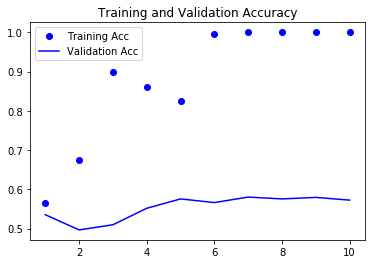

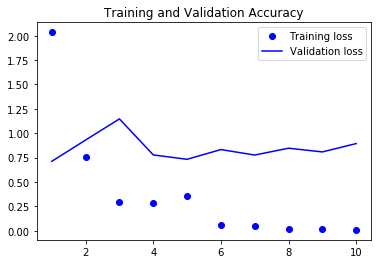

In [30]:
# 绘制结果
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

  如果不使用预训练的词向量模型进行训练，将词嵌入和模型一起进行训练，得到的验证精度在50%以上。增加训练集数量后，不用预训练的精度将会上升到更好的情况（更适应了当前的应用场景下的词向量）。